In [1]:
#import modules
import numpy as np
import pandas as pd
import time
import math
from keras import backend as K 
from keras.engine.training import Model
from tensorflow.keras.utils import to_categorical, plot_model
from keras.models import Sequential, load_model
from sklearn.preprocessing import MinMaxScaler
from keras.layers.convolutional import Conv1D, Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Dropout, Activation, Flatten
from keras.layers import LSTM, Dense, Input
from keras.optimizers import SGD
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error

In [2]:
#reading CSV data
df = pd.read_csv('./Sub0-RAW.csv')
df.head()

,Dates,Year,Month,Day,Hours,Precipitation,Temperature,Outflow
0,10/1/1980,1980,10,1,0:00:00,0.0,102.992,5.0
1,10/1/1980,1980,10,1,1:00:00,0.0,97.790,5.0
2,10/1/1980,1980,10,1,2:00:00,0.0,92.588,5.0
3,10/1/1980,1980,10,1,3:00:00,0.0,87.404,5.0
4,10/1/1980,1980,10,1,4:00:00,0.0,85.172,5.0


In [3]:
#define train and label column
train_cols = ["Precipitation","Temperature","Outflow"]
label_cols = ["Outflow(t+1)"]

In [4]:
#filter the columns that are used for training and testing
filtered_df = df.filter(train_cols, axis=1)

In [5]:
#To convert from hourly data to daily data
oflow = filtered_df['Outflow'].tolist()
tem = filtered_df['Temperature'].tolist()
precp = filtered_df['Precipitation'].tolist()

#Summing up the outflow data
lengthOfData = len(oflow)

#summing 24 hours outflow
totalOutflow = []
for i in range(0, lengthOfData, 24):
  totalOutflow.append(sum(oflow[i:i+24]))

#averaging 24 hours temperature
averageTemperature = []
for i in range(0, lengthOfData, 24):
  averageTemperature.append((sum(tem[i:i+24]))/24)

#summing 24 hours precipitation
totalPrecipitation = []
for i in range(0, lengthOfData, 24):
  totalPrecipitation.append(sum(precp[i:i+24]))

In [6]:
#new dataframe for daily data
new_df = pd.DataFrame({'Precipitation': totalPrecipitation, 'Temperature': averageTemperature, 
                       'Outflow': totalOutflow}, columns=['Precipitation', 'Temperature', 'Outflow'])

In [7]:
#instantiating different Min Max scalar Normalization for trainning and testing data
xtrain_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
ytrain_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
xtest_min_max_scaler = MinMaxScaler(feature_range = (0, 1))
ytest_min_max_scaler = MinMaxScaler(feature_range = (0, 1))

In [8]:
#function to shift the time_series data for getting labels
def lag_seq(df, n_seq):
    for i in range(n_seq):
        df['Outflow(t+%d)' %(i+1)] = new_df['Outflow'].shift(-(i+1))
    return df

# building timeseries data with given timesteps
def timeseries(X, Y, Y_actual, time_steps, out_steps):
    input_size_0 = X.shape[0] - time_steps
    input_size_1 = X.shape[1]
    X_values = np.zeros((input_size_0, time_steps, input_size_1))
    Y_values = np.zeros((input_size_0,))
    Y_values_actual = np.zeros((input_size_0,))
    
    for i in tqdm_notebook(range(input_size_0)):
        X_values[i] = X[i:time_steps+i]
        Y_values[i] = Y[time_steps+i-1, 0]
        Y_values_actual[i] = Y_actual[time_steps+i-1, 0]
        
    print("length of time-series i/o",X_values.shape,Y_values.shape)
    return X_values, Y_values, Y_values_actual

#getting data ready for training the model
def data_processing(lag_df):
    #Splitting training and test data
    df_train, df_test = train_test_split(lag_df, train_size=0.8, test_size=0.2, shuffle=False)
    x_train = df_train.loc[:,train_cols].values
    y_train = df_train.loc[:,label_cols].values
    x_test = df_test.loc[:,train_cols].values
    y_test = df_test.loc[:,label_cols].values    
   
    #Normalizing training data
    x_train_nor = xtrain_min_max_scaler.fit_transform(x_train)
    y_train_nor = ytrain_min_max_scaler.fit_transform(y_train)

    # Normalizing test data
    x_test_nor = xtest_min_max_scaler.fit_transform(x_test)
    y_test_nor = ytest_min_max_scaler.fit_transform(y_test)
    
    # Saving actual train and test y_label to calculate mean square error later after training
    y_train_actual = y_train
    y_test_actual = y_test
    
    #Building timeseries
    X_Train, Y_Train, Y_train_actual = timeseries(x_train_nor, y_train_nor, y_train_actual, time_steps=18, out_steps=1)
    X_Test, Y_Test, Y_test_actual = timeseries(x_test_nor, y_test_nor, y_test_actual, time_steps=18, out_steps=1)
    
    return X_Train, Y_Train, Y_train_actual, X_Test, Y_Test, Y_test_actual

In [9]:
#calling function to create lag dataframe
lag_df = lag_seq(new_df, 1)
lag_df.dropna(inplace=True)
X_Train, Y_Train, Y_train_actual, X_Test, Y_Test, Y_test_actual = data_processing(lag_df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app



length of time-series i/o (6166, 18, 3) (6166,)



length of time-series i/o (1528, 18, 3) (1528,)


In [10]:
#Splitting X_Train and Y_Train into validation and Training data
len_train = math.floor(0.9*len(X_Train))
len_valid = len(X_Train)
X_Val, Y_Val = X_Train[len_train:len_valid], Y_Train[len_train:len_valid]
X_Trn, Y_Trn = X_Train[:len_train], Y_Train[:len_train]

In [11]:
# Function to Build Model
def make_model(X_Train):
    input_layer = Input(shape=(X_Train.shape[1], X_Train.shape[2]))

    conv1 = Conv1D(filters=16, kernel_size=3, strides=1,
                    padding='same',activation='relu')(input_layer)
    conv2 = Conv1D(filters=32, kernel_size=3,strides = 1,
                          padding='same', activation='relu')(conv1)
    conv3 = Conv1D(filters=64, kernel_size=3,strides = 1,
                          padding='same', activation='relu')(conv2)

    flatten = Flatten()(conv3)

    dense1 = Dense(1152, activation='relu')(flatten)
    dense2 = Dense(576, activation='relu')(dense1)
    output_layer = Dense(1, activation='linear')(dense2)
    
    return Model(inputs=input_layer, outputs=output_layer)

In [12]:
#lists to save different parameters while training
mse_for_iter = []
train_loss_over_epoch = []
val_loss_over_epoch = []
predicted_y_values_unnors = []
models = []
#function to iterate training
def run_iteration(no_iter=20, epochs = 10):      
    start_time = time.time() 
    for iteration in range(no_iter):
        print(f'Iteration: {iteration + 1}')
        K.clear_session()                        #clears sesssion after every training iteration to record new MSE
        model = make_model(X_Train)
        #plot_model(model, show_shapes=True)
        model.compile(optimizer = 'adam', loss = 'mean_squared_error')
        history = model.fit(X_Trn, Y_Trn, epochs=epochs,
                       validation_data=(X_Val, Y_Val))
        train_loss_over_epoch.append(history.history['loss'])
        val_loss_over_epoch.append(history.history['val_loss'])
        predicted_y_values = model.predict(X_Test)
        predicted_y_values_unnor = ytrain_min_max_scaler.inverse_transform(predicted_y_values)
        mse_for_iter.append(mean_squared_error(predicted_y_values_unnor, Y_test_actual))
        predicted_y_values_unnors.append(predicted_y_values_unnor)
        models.append(model)
        
    end_time = time.time()
    print('--------------------------\n')
    print(f'Starting time: {start_time}')
    print(f'Completing time: {end_time}')
    print(f'It took {(start_time - end_time)/60} minutes to train the model for {no_iter} iterations')
    #return predicted unnormalized values for test set from last iteration 
    return predicted_y_values_unnor, model

predicted_y_values_unnor, model = run_iteration(20,10)

Iteration: 1
Epoch 1/10
174/174 [==============================] - 45s 10ms/step - loss: 0.0200 - val_loss: 0.0039
Epoch 2/10
174/174 [==============================] - 1s 6ms/step - loss: 0.0015 - val_loss: 0.0036
Epoch 3/10
174/174 [==============================] - 1s 6ms/step - loss: 0.0018 - val_loss: 0.0033
Epoch 4/10
174/174 [==============================] - 1s 6ms/step - loss: 0.0015 - val_loss: 0.0035
Epoch 5/10
174/174 [==============================] - 1s 6ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 6/10
174/174 [==============================] - 1s 6ms/step - loss: 0.0015 - val_loss: 0.0033
Epoch 7/10
174/174 [==============================] - 1s 6ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 8/10
174/174 [==============================] - 1s 6ms/step - loss: 0.0014 - val_loss: 0.0035
Epoch 9/10
174/174 [==============================] - 1s 6ms/step - loss: 0.0012 - val_loss: 0.0033
Epoch 10/10
174/174 [==============================] - 1s 6ms/step - loss: 0.0011 - v

In [13]:
#Saving the trained model
model.save("cnn_model1_three_features.hdf5")

# Function to visualize
1. Mean Square Error over different training iterations
2. Training and validation loss over epochs for each iterations
3. Actual vs. predicted values plot

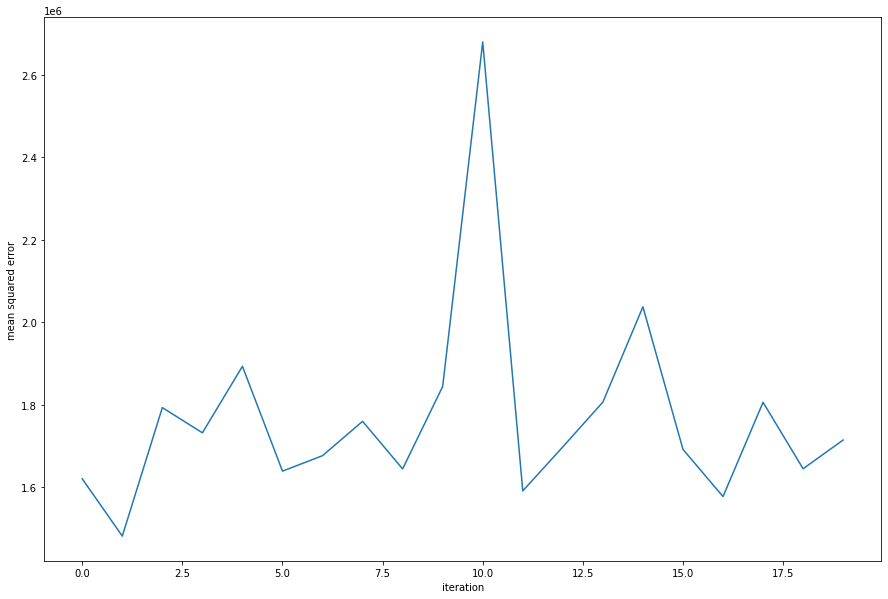

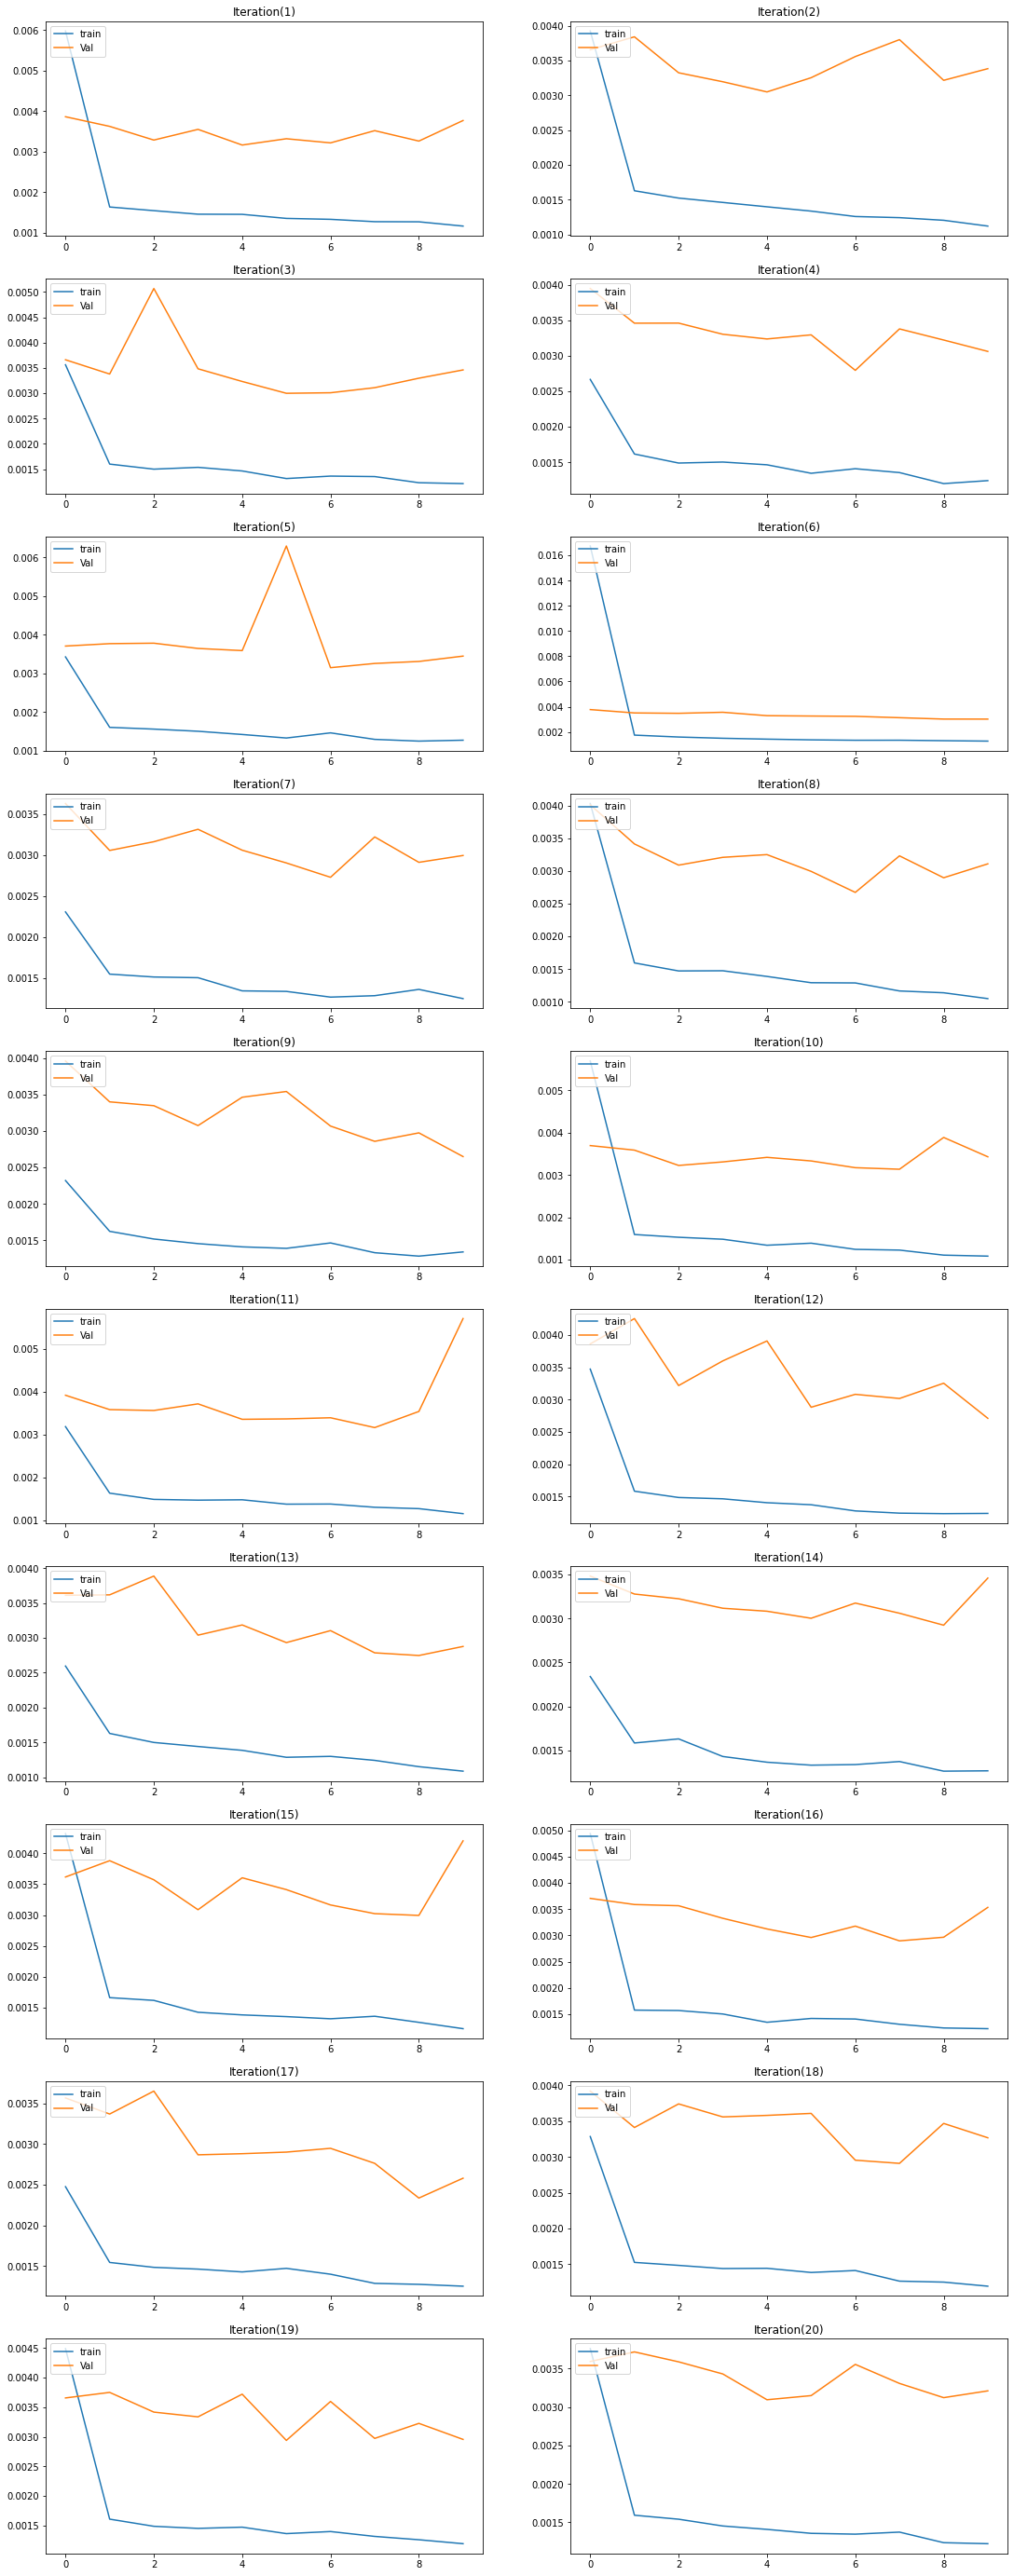

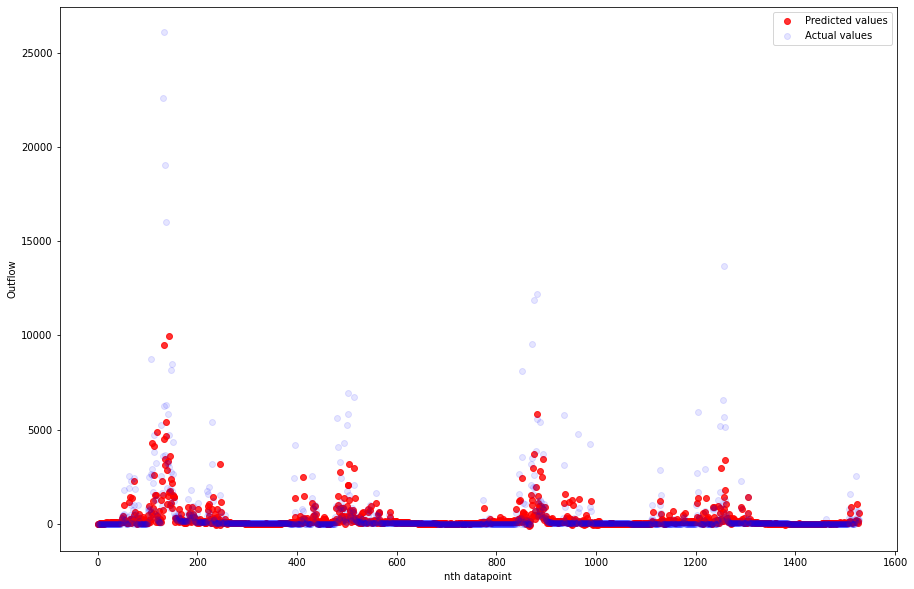

In [14]:
# Function to visualize:
def plot_evaluation():
    #mean square error over iterations
    plt.figure(figsize=(15, 10))
    plt.plot(mse_for_iter)
    plt.ylabel('mean squared error')
    plt.xlabel('iteration')
    plt.savefig('mse.png', bbox_inches='tight')
    plt.show()
        
    #plot train and validation loss over epochs for each iteration
    fig, axs = plt.subplots(10, 2)
    #axs.set_ylabel('loss')
    #axs.set_xlabel('epoch')
    fig.set_size_inches(18.5, 50)
    for row in range(10):
        for col in range(2):
            index = 2*row + col #index to get loss from training loss and validation loss list
            axs[row, col].plot(train_loss_over_epoch[index])
            axs[row, col].plot(val_loss_over_epoch[index])
            axs[row, col].set_title('Iteration(%d)' %(index+1))
            axs[row, col].legend(['train', 'Val'], loc='upper left')            
    plt.savefig('train_val_loss.png', bbox_inches='tight')
    
    #plot predicted value vs actual values from last iteration
    plt.figure(figsize=(15, 10))
    plt.plot(predicted_y_values_unnor, 'ro', alpha=0.8)
    plt.plot(Y_test_actual, 'bo', alpha=0.1)
    plt.legend(['Predicted values', 'Actual values'], loc='upper right')
    plt.ylabel('Outflow')
    plt.xlabel('nth datapoint')
    plt.savefig('predicted_values_visuals.png', bbox_inches='tight')
    plt.show()
    
#call plot_evaluation function
plot_evaluation()

In [15]:
#list of MSE over all iterations
mse_for_iter

[1620902.4870637287,
 1482144.1428896177,
 1793315.0557630952,
 1732271.743063146,
 1893279.6308157095,
 1639458.4102032068,
 1676889.2411459337,
 1760095.568232586,
 1644851.8410377041,
 1844480.5675041792,
 2678966.627276016,
 1591523.2575478826,
 1698245.5333844004,
 1806641.010178632,
 2037453.6274437297,
 1692156.593892842,
 1577898.1354601693,
 1806160.7477638521,
 1645248.6241358176,
 1714850.8122102167]

In [16]:
# Mean MSE over all iterations
print(np.mean(mse_for_iter))

1766841.682850623


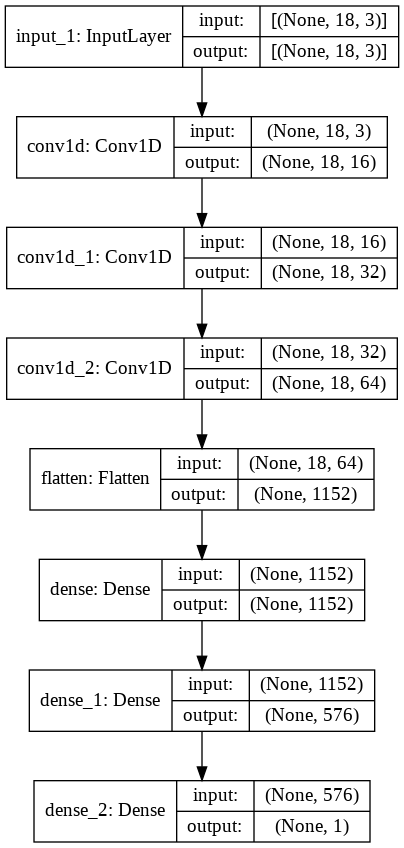

In [17]:
#Plotting model used for training
plot_model(model, show_shapes=True)